# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
import scipy.stats as stats
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

import warnings
warnings.filterwarnings('ignore')

cuda


### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

In [4]:
def power_spec_dist_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_power_spec_list = []
        std_power_spec_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue
            # TODO Go through and check to see if one of the seeds didn't finish.
            #      If so, make that the new end_ind if it is less than the end_ind 
            #      given.

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                dt = time_arr[2]-time_arr[1]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt,device=device)
                power_spec_list += [power_spec]
            power_spec_mat = torch.stack([avg for avg in power_spec_list])
            
            avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
            std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(freqs, 
                                (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                                color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        # _ = ax.set_ylim(0.0001)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()
        pass

In [5]:
def power_spec_ang_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_power_spec_list = []
        std_power_spec_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue
            # TODO Go through and check to see if one of the seeds didn't finish.
            #      If so, make that the new end_ind if it is less than the end_ind 
            #      given.

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                dt = time_arr[2]-time_arr[1]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                n_beads = com_arr.shape[0]
                power_spec, freqs  = cps.poly_ang_power_spec(com_arr,dt,device=device)
                power_spec_list += [power_spec]
            power_spec_mat = torch.stack([avg for avg in power_spec_list])
            
            avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
            std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(freqs, 
                                (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                                color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Real ang power spectrum \n' + r'Re$[\langle \tilde{\hat{r}}(\omega)\cdot\tilde{\hat{r}}^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        # _ = ax.set_ylim(0.0001)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()
        pass

In [6]:
def power_spec_graph_func(fig, axarr, data_path, param_str, label_str,
                        ss_ind=1,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None):
    try:
        axarr[0,0].sharey(axarr[0,1])
        axarr[0,0].sharex(axarr[0,1])
        axarr[1,0].sharex(axarr[1,1])
        axarr[1,0].sharey(axarr[1,1])

        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))
        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]

        # Make color scale
        log_pvs = np.log10(param_vals)
        norm_log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(norm_log_pvs)

        avg_power_spec_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                power_spec = cps.power_spec(com_arr, device)
                n_ps_pos_vals = int(power_spec.size(dim=0)/2)
                freq = torch.fft.fftfreq(power_spec.size(dim=0), time_arr[2]-time_arr[1])[:n_ps_pos_vals]

                _ = axarr[0, 0].plot(freq, power_spec.real.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)
                _ = axarr[1, 0].plot(freq, power_spec.imag.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)

                power_spec_list += [power_spec[:n_ps_pos_vals]]

            power_spec_mat = torch.stack([avg for avg in power_spec_list])
            
            avg_power_spec_list += [power_spec_mat.mean(axis=0)]
            # std_auto_corr_list += [power_spec_mat.std(axis=0)]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
            
            # Make sure you get the right scale of the frequency array
            #   Nyquist frequency should be 1/(2 * \Delta t)
            # n_ps_pos_vals = int(avg_power_spec_list[-1][:min_length].size(dim=0)/2)
            # freq_arr = torch.fft.fftfreq(avg_power_spec_list[-1][:min_length].size(dim=0), time_arr[2]-time_arr[1])[:n_ps_pos_vals]

            _ = axarr[0, 1].plot(freq, avg_power_spec_list[-1].real.to('cpu'), 
                                 color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[1, 1].plot(freq, avg_power_spec_list[-1].imag.to('cpu'), 
                                 color=colors[i], label=f"$ k_o = {label}$")
        
        _ = axarr[0,0].set_ylabel('Real power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = axarr[1,0].set_ylabel('Imaginary power spectrum \n' + r'Im$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = axarr[0,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[0,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[0,0].set_yscale('log')
        _ = axarr[0,0].set_xscale('log')
        _ = axarr[1,0].set_yscale('log')
        _ = axarr[1,0].set_xscale('log')

        _ = axarr[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [22]:
def graph_power_spec_ax(fig, ax, h5_path, 
                colorbar_label='', 
                ci_bound = .95,
                label_str= '{}',
                show_legend=True,
                send_cut_ind = 2,
                fend_cut_ind = -1,
                          ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            p_grp = h5d[pv]
            time_arr = p_grp['freqs'][send_cut_ind:fend_cut_ind]
            mean_ps_arr = p_grp['power_spec'][send_cut_ind:fend_cut_ind,0]
            std_ps_arr = p_grp['power_spec'][send_cut_ind:fend_cut_ind,1]

            _ = ax.plot(time_arr, mean_ps_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_ps_arr/np.sqrt(p_grp.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_ps_arr - ci, mean_ps_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        _ = ax.set_ylabel('Power spectrum \n' + r'Re$[\langle \tilde{{\bf R}}_i(\omega)\cdot\tilde{{\bf R}}_i^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [23]:
def graph_dist_power_spec_ax(fig, ax, h5_path, 
                colorbar_label='', 
                ci_bound = .95,
                label_str= '{}',
                show_legend=True,
                send_cut_ind = 2,
                fend_cut_ind = -1,
                          ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            p_grp = h5d[pv]
            time_arr = p_grp['freqs'][send_cut_ind:fend_cut_ind]
            mean_ps_arr = p_grp['dist_power_spec'][send_cut_ind:fend_cut_ind,0]
            std_ps_arr = p_grp['dist_power_spec'][send_cut_ind:fend_cut_ind,1]

            _ = ax.plot(time_arr, mean_ps_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_ps_arr/np.sqrt(p_grp.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_ps_arr - ci, mean_ps_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, lbel='SAW $R_g$')
        _ = ax.set_ylabel('Dist power spectrum \n' + r'Re$[\langle \tilde{R}_i(\omega)\tilde{R}_i^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [24]:
def graph_ang_power_spec_ax(fig, ax, h5_path, 
                colorbar_label='', 
                ci_bound = .95,
                label_str= '{}',
                show_legend=True,
                send_cut_ind = 2,
                fend_cut_ind = -1,
                          ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            p_grp = h5d[pv]
            time_arr = p_grp['freqs'][send_cut_ind:fend_cut_ind]
            mean_ps_arr = p_grp['ang_power_spec'][send_cut_ind:fend_cut_ind,0]
            std_ps_arr = p_grp['ang_power_spec'][send_cut_ind:fend_cut_ind,1]

            _ = ax.plot(time_arr, mean_ps_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_ps_arr/np.sqrt(p_grp.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_ps_arr - ci, mean_ps_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        _ = ax.set_ylabel('Ang power spectrum \n' + r'Re$[\langle \tilde{\hat{R}}_i(\omega)\cdot\tilde{\hat{R}}_i^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [10]:
def save_power_spec_run_data(run_path, param_str, 
                    ss_ind = 1, end_ind = -1,
                    start_bead = 0, end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'power_spec_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

    
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            dist_power_spec_list = []
            ang_power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                dt = time_arr[2]-time_arr[1]

                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                power_spec, freqs = cps.power_spec(com_arr, dt)
                power_spec_list += [power_spec.tolist()]

                dist_power_spec, freqs  = cps.poly_dist_power_spec(com_arr, dt)
                dist_power_spec_list += [dist_power_spec.tolist()]

                ang_power_spec, freqs  = cps.poly_ang_power_spec(com_arr, dt)
                ang_power_spec_list += [ang_power_spec.tolist()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in power_spec_list])
            power_spec_arrs = np.array([ps[-min_length:] for ps in power_spec_list])
            dist_power_spec_arrs = np.array([ps[-min_length:] for ps in dist_power_spec_list])
            ang_power_spec_arrs = np.array([ps[-min_length:] for ps in ang_power_spec_list])

            # Create parameter group
            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            p_grp = h5_file.create_group(label)
            p_grp.attrs['seeds'] = power_spec_arrs.shape[0]
            _ = p_grp.create_dataset('freqs', data=freqs[-min_length:])

            # Create full power spectrum dataset
            data_arr = np.hstack((power_spec_arrs.mean(axis=0)[:, np.newaxis],
                                  power_spec_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = p_grp.create_dataset('power_spec', data=data_arr)

            # Create distance power spectrum dataset
            data_arr = np.hstack((dist_power_spec_arrs.mean(axis=0)[:, np.newaxis],
                                  dist_power_spec_arrs.std(axis=0)[:, np.newaxis]))
            d_set = p_grp.create_dataset('dist_power_spec', data=data_arr)

            # Create angular power spectrum dataset
            data_arr = np.hstack((ang_power_spec_arrs.mean(axis=0)[:, np.newaxis],
                                  ang_power_spec_arrs.std(axis=0)[:, np.newaxis]))
            d_set = p_grp.create_dataset('ang_power_spec', data=data_arr)

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


# Data

In [11]:
data_dir_list = [
cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1", 
cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01", 
cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001", 
cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001", 
]

In [77]:
for dd in data_dir_list:
    save_power_spec_run_data(dd, 'kod') 

0it [00:00, ?it/s]

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


0it [00:00, ?it/s]

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


0it [00:00, ?it/s]

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


0it [00:00, ?it/s]

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


In [14]:
save_power_spec_run_data(data_dir_list[0], 'kod')

0it [00:00, ?it/s]

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


# Graphing

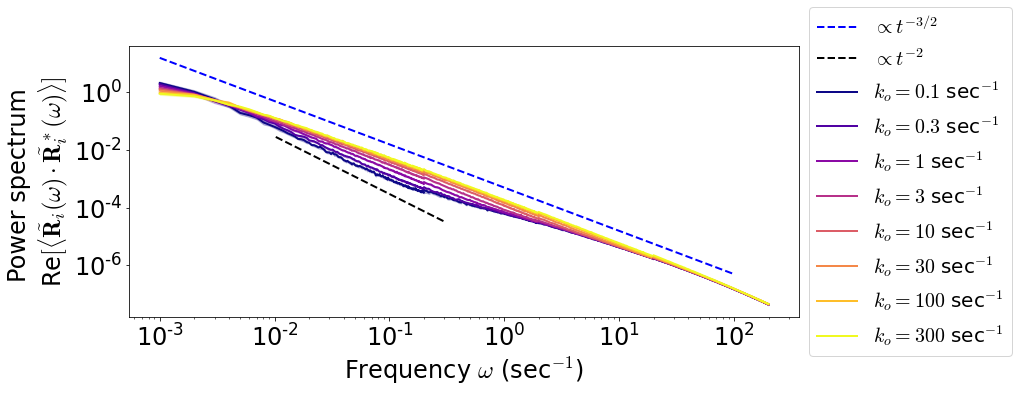

In [25]:
fig, axarr = plt.subplots(1,1, figsize=(12, 5))
# Straight lines
freq_arr = np.logspace(-3, 2, 100)
_ = axarr.plot(freq_arr, .0005*np.power(freq_arr, -1.5), c='b', linestyle='--', label= "$\propto t^{-3/2}$")
_ = axarr.plot(freq_arr[20:50], .000003*np.power(freq_arr, -2)[20:50], c='k', linestyle='--', label= "$\propto t^{-2}$")

graph_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=True, send_cut_ind = 1, fend_cut_ind = 200)
graph_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 20, fend_cut_ind = 200)
graph_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 20, fend_cut_ind = 200)
graph_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 20, fend_cut_ind = 200)

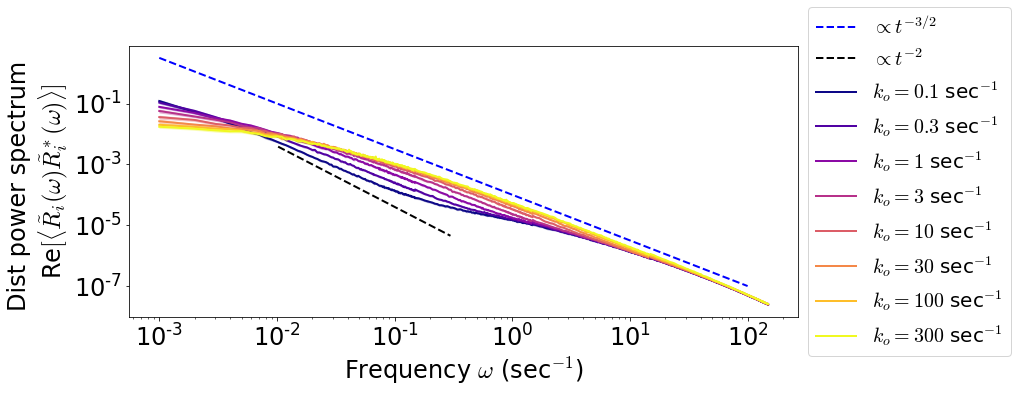

In [26]:
fig, axarr = plt.subplots(1,1, figsize=(12, 5))
# Straight lines
freq_arr = np.logspace(-3, 2, 100)
_ = axarr.plot(freq_arr, .0001*np.power(freq_arr, -1.5), c='b', linestyle='--', label= "$\propto t^{-3/2}$")
_ = axarr.plot(freq_arr[20:50], .0000004*np.power(freq_arr, -2)[20:50], c='k', linestyle='--', label= "$\propto t^{-2}$")
# _ = axarr.plot(freq_arr[50:70], .000008*np.power(freq_arr, -.5)[50:70], c='r', linestyle='--', label= "$\propto t^{-1/2}$")

graph_dist_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=True, send_cut_ind = 1, fend_cut_ind = 150)
graph_dist_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 15, fend_cut_ind = 150)
graph_dist_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 15, fend_cut_ind = 150)
graph_dist_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 15, fend_cut_ind = 150)

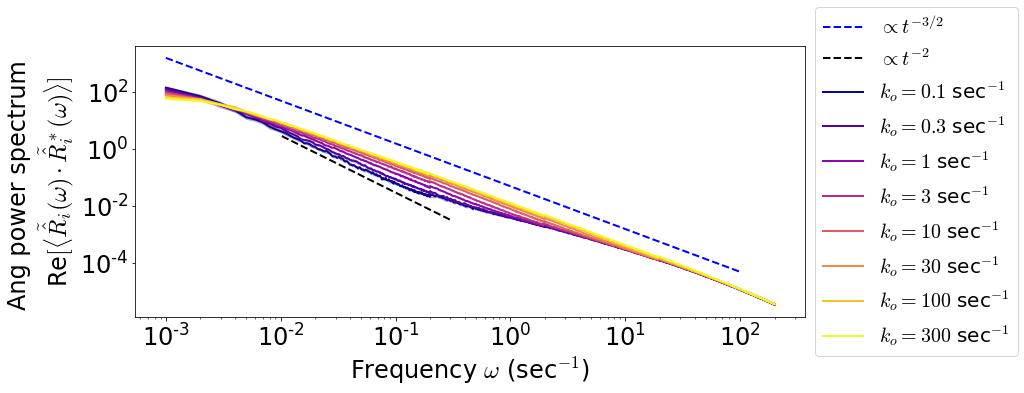

In [27]:
fig, axarr = plt.subplots(1,1, figsize=(12, 5))
# Straight lines
freq_arr = np.logspace(-3, 2, 100)
_ = axarr.plot(freq_arr, .05*np.power(freq_arr, -1.5), c='b', linestyle='--', label= "$\propto t^{-3/2}$")
_ = axarr.plot(freq_arr[20:50], .0003*np.power(freq_arr, -2)[20:50], c='k', linestyle='--', label= "$\propto t^{-2}$")
# _ = axarr.plot(freq_arr[50:70], .0008*np.power(freq_arr, -.5)[50:70], c='r', linestyle='--', label= "$\propto t^{-1/2}$")

graph_ang_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=True, send_cut_ind = 1, fend_cut_ind = 200)
graph_ang_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 20, fend_cut_ind = 200)
graph_ang_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 20, fend_cut_ind = 200)
graph_ang_power_spec_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/power_spec_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 20, fend_cut_ind = 200)

# Convergence

0it [00:00, ?it/s]

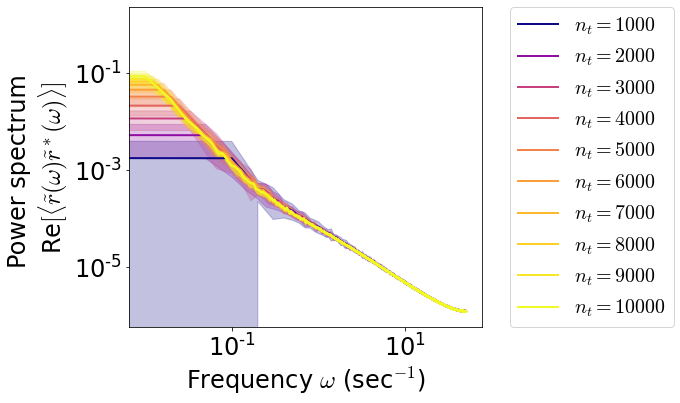

In [10]:
pd = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1"

# time_snap_list = (np.power(2, np.arange(9,14)) - 1).tolist()
time_snap_list = (np.arange(1000,11000,1000)).tolist()
ci_bound=.95
end_ind=-1
start_bead=0
end_bead=None
label_str = '$n_t$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, ss_ind in tqdm(enumerate(time_snap_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, -ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            power_spec, freqs  = cps.power_spec(com_arr, dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

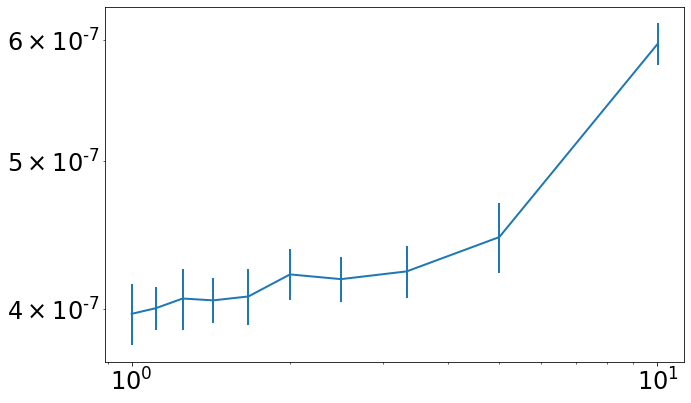

In [11]:
pd = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1"

# time_snap_list = (np.power(2, np.arange(9,14)) - 1).tolist()
time_snap_list = (np.arange(1000,11000,1000)).tolist()
ci_bound=.95
end_ind=-1
start_bead=0
end_bead=None
label_str = '$N_t$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    # log_pvs = np.log10(time_snap_list)
    # log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    # colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    inv_time_wind_list = []
    std_power_spec_list = []
    for i, ss_ind in tqdm(enumerate(time_snap_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, -ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt, device=device)
            power_spec_list += [float(power_spec[-250].real)]

        # power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [np.mean(power_spec_list)]
        inv_time_wind_list += [1./(dt*(time_arr[ss_ind]))]
        std_power_spec_list += [np.std(power_spec_list)]
        
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        # ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        # _ = ax.fill_between(freqs, 
        #                     (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
        #                     color=colors[i], alpha=.25)

    _ = ax.errorbar(inv_time_wind_list, avg_power_spec_list, yerr=std_power_spec_list)
    # _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    # _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    # _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass
# for different size windows


0it [00:00, ?it/s]

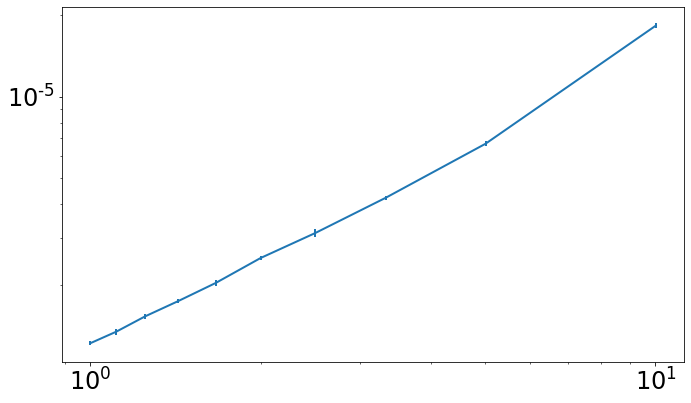

In [15]:
pd = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1"

# time_snap_list = (np.power(2, np.arange(9,14)) - 1).tolist()
time_snap_list = (np.arange(1000,11000,1000)).tolist()
ci_bound=.95
end_ind=-1
start_bead=0
end_bead=None
label_str = '$N_t$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    # log_pvs = np.log10(time_snap_list)
    # log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    # colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    inv_time_wind_list = []
    std_power_spec_list = []
    for i, ss_ind in tqdm(enumerate(time_snap_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, -ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = cps.power_spec(com_arr,dt, device=device)
            power_spec_list += [float(power_spec[-250].real)]

        # power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [np.mean(power_spec_list)]
        inv_time_wind_list += [1./(dt*(time_arr[ss_ind]))]
        std_power_spec_list += [np.std(power_spec_list)]
        
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        # ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        # _ = ax.fill_between(freqs, 
        #                     (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
        #                     color=colors[i], alpha=.25)

    _ = ax.errorbar(inv_time_wind_list, avg_power_spec_list, yerr=std_power_spec_list)
    # _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    # _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    # _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass
# for different size windows


0it [00:00, ?it/s]

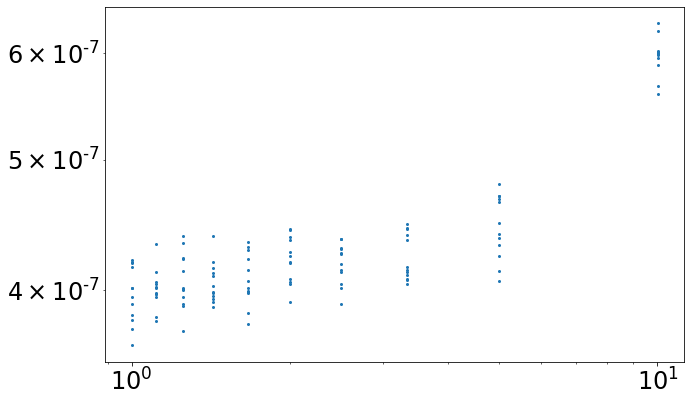

In [14]:
pd = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1"

# time_snap_list = (np.power(2, np.arange(9,14)) - 1).tolist()
time_snap_list = (np.arange(1000,11000,1000)).tolist()
ci_bound=.95
end_ind=-1
start_bead=0
end_bead=None
label_str = '$N_t$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    # log_pvs = np.log10(time_snap_list)
    # log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    # colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    inv_time_wind_list = []
    std_power_spec_list = []
    power_spec_list = []
    for i, ss_ind in tqdm(enumerate(time_snap_list)):
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, -ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec[-250].real]
            inv_time_wind_list += [1./(dt*(time_arr[ss_ind]))]

        # power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        # avg_power_spec_list += [np.mean(power_spec_list)]
        # std_power_spec_list += [np.std(power_spec_list)]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        # ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        # _ = ax.fill_between(freqs, 
        #                     (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
        #                     color=colors[i], alpha=.25)

    _ = ax.scatter(inv_time_wind_list, power_spec_list)
    # _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    # _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    # _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass
# for different size windows


[4.02676981e-07 1.86501677e-09 2.01562719e+00]


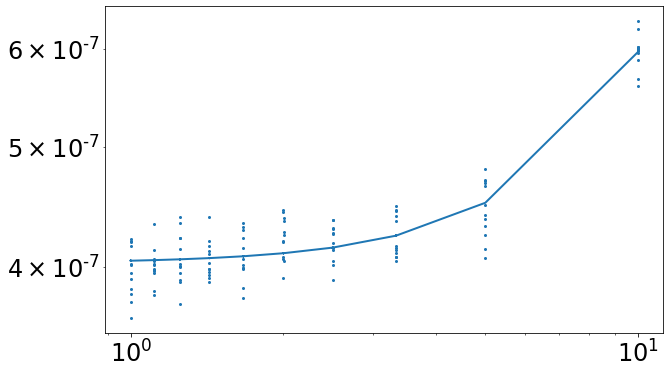

In [15]:
def line_func(x, a, b):
    return a*x + b

def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM

params, cv = curve_fit(func_powerlaw, inv_time_wind_list, power_spec_list)
# params, cv = curve_fit(line_func, np.log(inv_time_wind_list), np.log(power_spec_list), p0=(0,1))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
_ = ax.scatter(inv_time_wind_list, power_spec_list)
_ = ax.plot(inv_time_wind_list, func_powerlaw(np.array(inv_time_wind_list), *params))
# _ = ax.plot(inv_time_wind_list, np.exp(line_func(np.log(inv_time_wind_list), *params)))
print(params)

_ = ax.set_yscale('log')
_ = ax.set_xscale('log')

[ 6.07217970e-11 -3.67520563e-11]


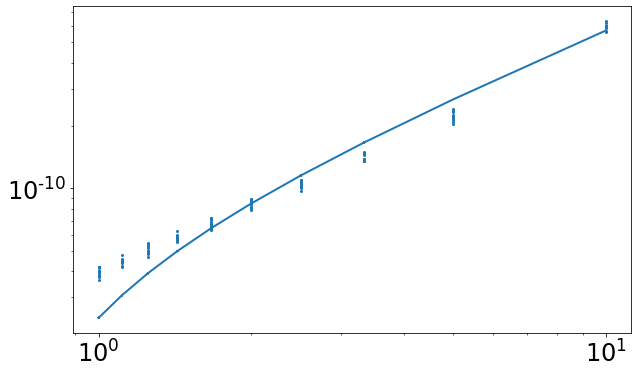

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

params, cv = curve_fit(line_func, inv_time_wind_list, power_spec_list, p0=(0,1))

_ = ax.scatter(inv_time_wind_list, power_spec_list)
_ = ax.plot(inv_time_wind_list, line_func(np.array(inv_time_wind_list), *params))
print(params)

_ = ax.set_yscale('log')
_ = ax.set_xscale('log')

ValueError: only one element tensors can be converted to Python scalars

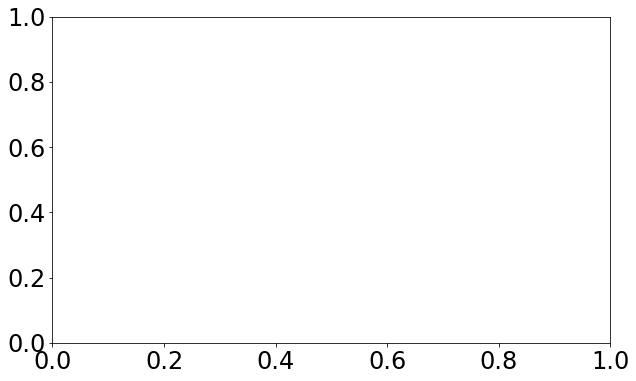

In [126]:
def line_func(x, a, b):
    return a*x + b

def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# params, cv = curve_fit(func_powerlaw, inv_time_wind_list, power_spec_list)
# _ = ax.plot(inv_time_wind_list, func_powerlaw(np.array(inv_time_wind_list), *params))

params, cv = curve_fit(line_func, np.log(inv_time_wind_list), np.log(power_spec_list), p0=(0,1))

_ = ax.scatter(inv_time_wind_list, power_spec_list)
_ = ax.plot(inv_time_wind_list, np.exp(line_func(np.log(inv_time_wind_list), *params)))
print(params[0], np.exp(params[1]))

_ = ax.set_yscale('log')
_ = ax.set_xscale('log')

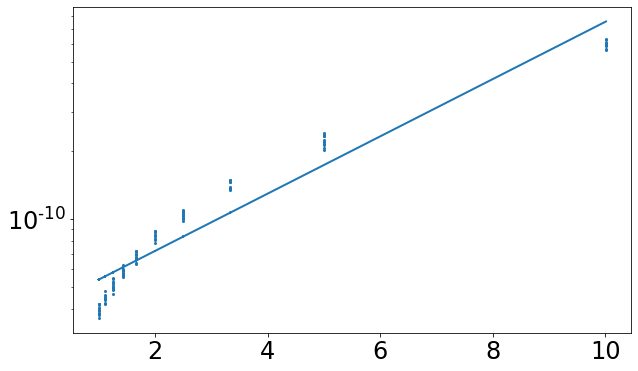

In [113]:
def line_func(x, a, b):
    return a*x + b

def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def monoExp(x, m, a):
    return m * np.exp(a * x)

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
_ = ax.scatter(inv_time_wind_list, power_spec_list)


params, cv = curve_fit(line_func, np.array(inv_time_wind_list), np.log(power_spec_list), p0=(0,.1*10))
_ = ax.plot(inv_time_wind_list, np.exp(line_func(np.array(inv_time_wind_list), *params)))

# params, cv = curve_fit(monoExp, np.array(inv_time_wind_list), power_spec_list, p0=(.1*10, 0.1))
# _ = ax.plot(inv_time_wind_list, monoExp(np.array(inv_time_wind_list), *params))

# print(params[0], np.exp(params[1]))

_ = ax.set_yscale('log')
# _ = ax.set_xscale('log')

In [18]:
pd = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1"

# time_snap_list = (np.power(2, np.arange(9,14)) - 1).tolist()
time_snap_list = (np.arange(5000,10100,400)).tolist()
ci_bound=.95
end_ind=None
start_bead=0
end_bead=None
label_str = '$N_t$'

try:

    avg_power_spec_list = []
    inv_time_wind_list = []
    for i, ss_ind in tqdm(enumerate(time_snap_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, -ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            power_spec, freqs  = cps.poly_dist_power_spec(com_arr, dt)
            power_spec_list += [power_spec.real]

        power_spec_mat = torch.stack([avg.to('cpu') for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat]
        inv_time_wind_list += [1./(dt*(time_arr[ss_ind]))]
        # std_power_spec_list += [np.std(power_spec_list)]
        
        for h5d in sd_h5_data_lst:
            h5d.close()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass



0it [00:00, ?it/s]

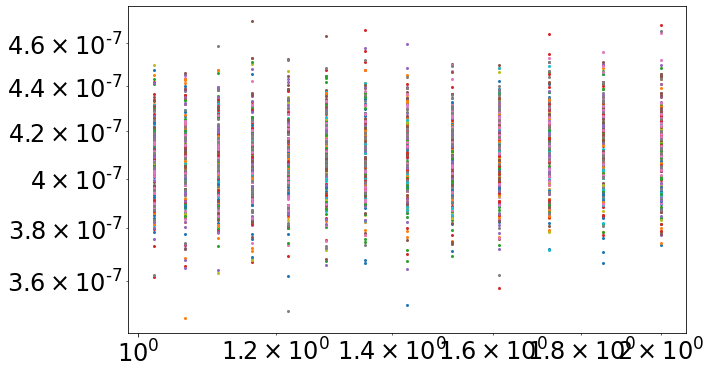

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
wind_freqs = []
intercepts = []
for ind in range(50, 500, 25):
    inv_wind_list = []
    ps_val_arr = []
    for ps_mat, inv_wind in zip(avg_power_spec_list, inv_time_wind_list):
        for ps_val in ps_mat[:, -ind]:
            ps_val_arr += [ps_val]
            inv_wind_list += [inv_wind]
    

    _ = ax.scatter(inv_wind_list, ps_val_arr)
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    

[ 4.09748744e-07 -8.59085416e-09 -2.07369072e+00]
[ 4.08994235e-07 -2.16319097e-06 -2.77278646e+02]
[ 4.03781125e-07  7.30321675e-09 -4.31611308e+00]
[ 5.24840153e-07 -1.14625320e-07 -5.60424920e-03]
[ 4.05047712e-05 -4.00971470e-05 -4.14346334e-04]
[ 9.58664024e-06 -9.17598779e-06 -5.33764037e-04]
[ 2.72494205e-05 -2.68402613e-05 -6.04481704e-04]
[ 3.00073875e-05 -2.95977780e-05 -6.87857211e-04]
[ 5.73078347e-05 -5.69018061e-05 -4.21775182e-04]
[ 4.80985686e-05 -4.76873394e-05 -4.80174902e-04]
[ 4.16387843e-05 -4.12281477e-05 -5.41727465e-04]
[ 7.25911248e-05 -7.21764751e-05 -5.95449936e-04]
[ 0.00052566 -0.00052524 -0.00034659]
[ 0.0006238  -0.00062338 -0.00033902]
[ 0.00062996 -0.00062952 -0.00037992]
[ 0.00179554 -0.00179512 -0.00029689]
[ 0.00174447 -0.00174405 -0.00032357]
[ 0.00151391 -0.00151348 -0.00037968]
[ 0.00195782 -0.00195741 -0.00035817]
[ 0.00211763 -0.00211722 -0.00034314]
[ 0.00235647 -0.00235606 -0.00030576]
[ 0.0021164  -0.00211599 -0.00034642]
[ 0.00214439 -0.0021

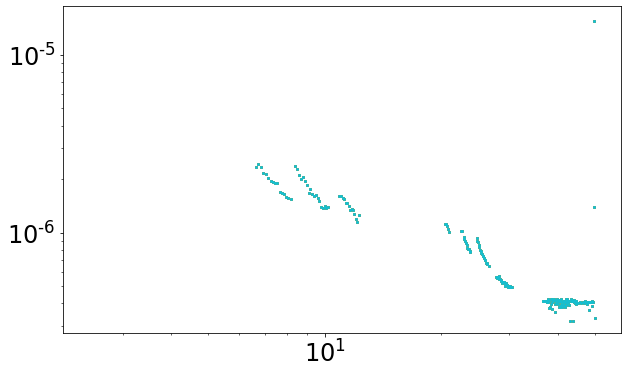

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
wind_freqs = []
intercepts = []
for ind in range(1, 5000, 10):
    inv_wind_list = []
    ps_val_arr = []
    for ps_mat, inv_wind in zip(avg_power_spec_list, inv_time_wind_list):
        try:
            for ps_val in ps_mat[:, -ind]:
                ps_val_arr += [ps_val]
                inv_wind_list += [inv_wind]
        except:
            pass
    try:
        params, cv = curve_fit(func_powerlaw, inv_wind_list, ps_val_arr)
        if params[2] < 0:
            print(params)
    except:
        pass
    if params[2] > 0:
        wind_freqs += [freqs[-ind]]
        intercepts += [params[0]]
    

    _ = ax.scatter(wind_freqs, intercepts)
    # _ = ax.set_ylim(.1**12, .1**9)
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    

# Figures

In [ ]:
def graph_power_spec_all_ax(fig, ax, h5_path, 
                          colorbar_label='', 
                          ci_bound = .95,
                          label_str= '{}',
                          show_legend=True):
    send_cut_ind = 2
    fend_cut_ind = -500
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            p_grp = h5d[pv]
            time_arr = p_grp['freqs'][send_cut_ind:fend_cut_ind]
            mean_msd_arr = h5_data[send_cut_ind:fend_cut_ind,1]
            std_msd_arr = h5_data[send_cut_ind:fend_cut_ind,2]

            _ = ax.plot(time_arr, mean_msd_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_msd_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_msd_arr - ci, mean_msd_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        
        _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        if show_legend:
            _ = ax.plot(time_arr, .1*time_arr, c='k', linestyle='--', label= "$\propto t$")
            _ = ax.plot(time_arr, .005*np.sqrt(time_arr), c='b', linestyle='--', label= "$\propto t^{1/2}$")
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

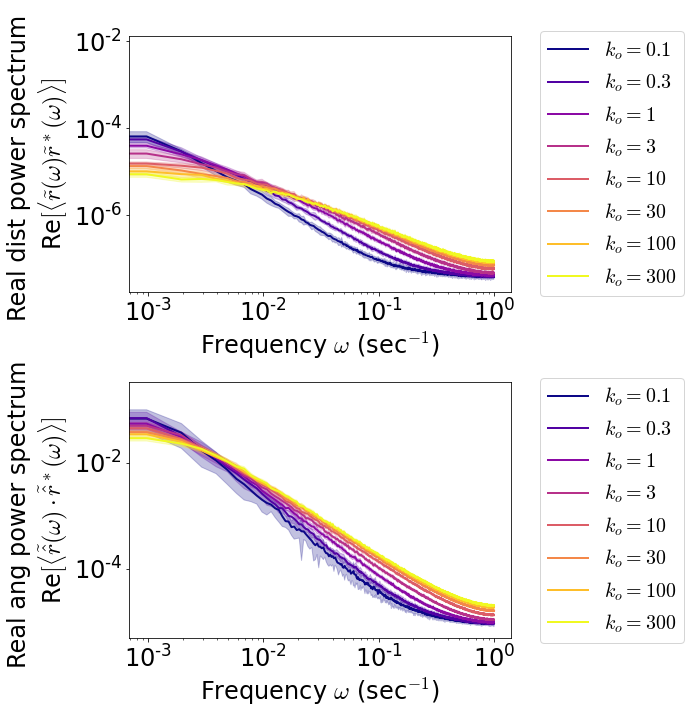

In [15]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")

fig, axarr = plt.subplots(2, 1, figsize=(10, 10))
power_spec_dist_graph_func_ci(fig, axarr[0], data_path, 'kod', '$k_o$',
                        ss_ind = -2047,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

power_spec_ang_graph_func_ci(fig, axarr[1], data_path, 'kod', '$k_o$',
                        ss_ind = -2047,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

(1.0000000000000006e-10, 0.010000000000000002)

0it [00:00, ?it/s]

(1.0000000000000006e-10, 1)

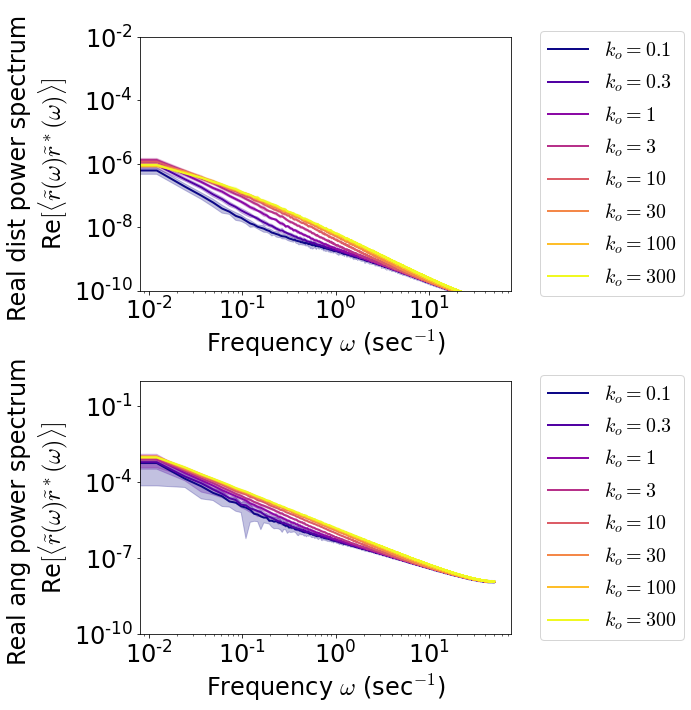

In [24]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations" 

fig, axarr = plt.subplots(2, 1, figsize=(10, 10))
power_spec_dist_graph_func_ci(fig, axarr[0], data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)
axarr[0].set_ylim(.1**10,.1**2)

power_spec_ang_graph_func_ci(fig, axarr[1], data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)
axarr[1].set_ylim(.1**10, 1)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

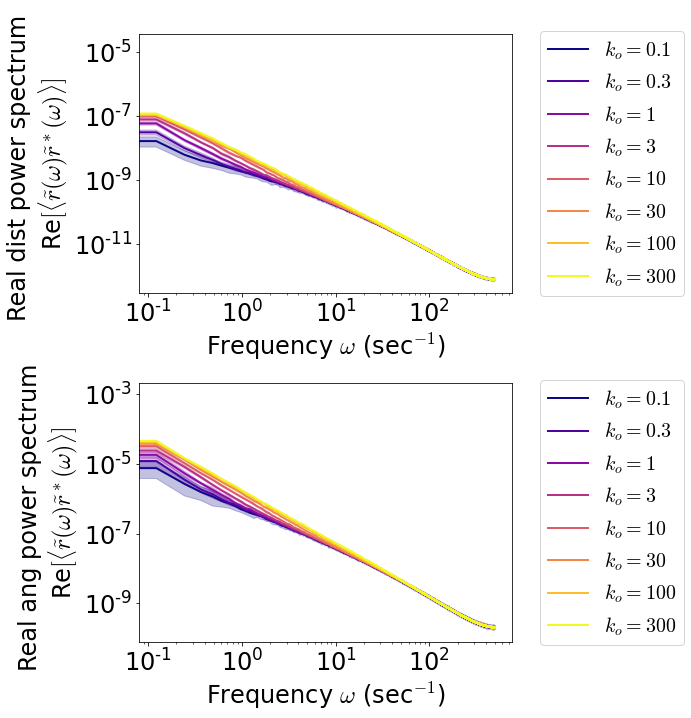

In [25]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations" 

fig, axarr = plt.subplots(2, 1, figsize=(10, 10))
power_spec_dist_graph_func_ci(fig, axarr[0], data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

power_spec_ang_graph_func_ci(fig, axarr[1], data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

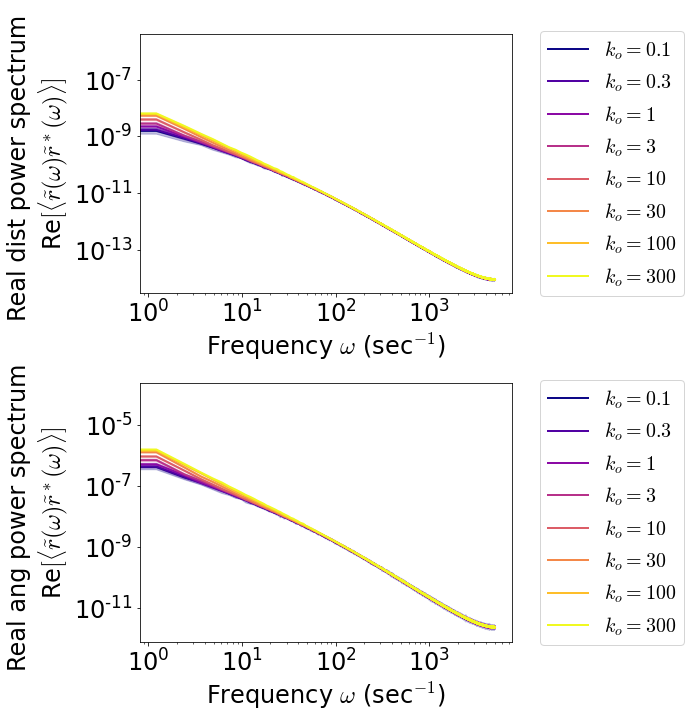

In [26]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations" 

fig, axarr = plt.subplots(2, 1, figsize=(10, 10))
power_spec_dist_graph_func_ci(fig, axarr[0], data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

power_spec_ang_graph_func_ci(fig, axarr[1], data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

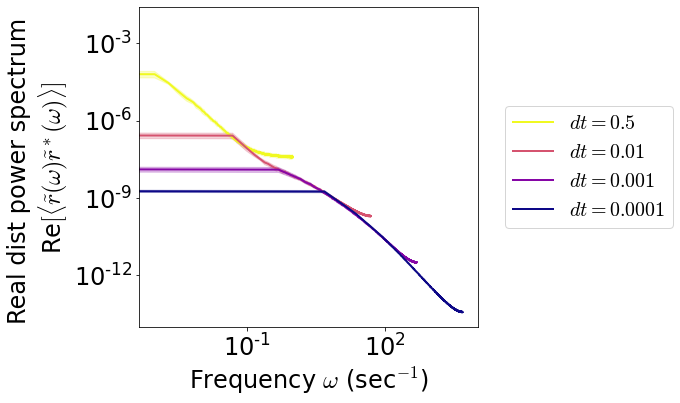

In [101]:
data_path_list = [cond_path / "22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod0.1"
                  ]
time_snap_list = [.5, .01, .001, .0001]
ci_bound=.95
ss_ind=-2047
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

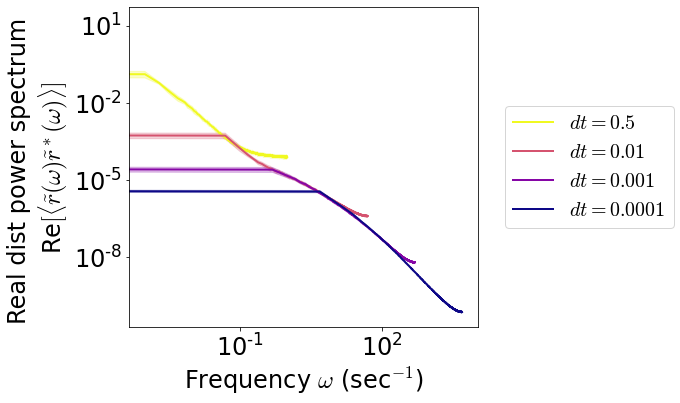

In [8]:
data_path_list = [cond_path / "22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod0.1"
                  ]
time_snap_list = [.5, .01, .001, .0001]
ci_bound=.95
ss_ind=-2047
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt, device = device)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

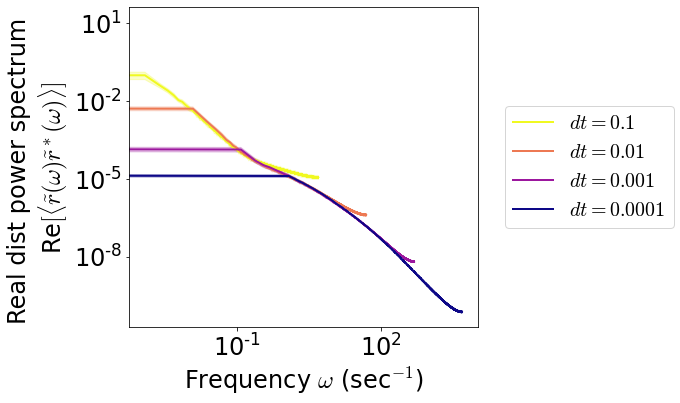

In [46]:
data_path_list = [
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod0.1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod0.1"
                  ]
time_snap_list = [.1, .01, .001, .0001]
ci_bound=.95
ss_ind=-8191
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

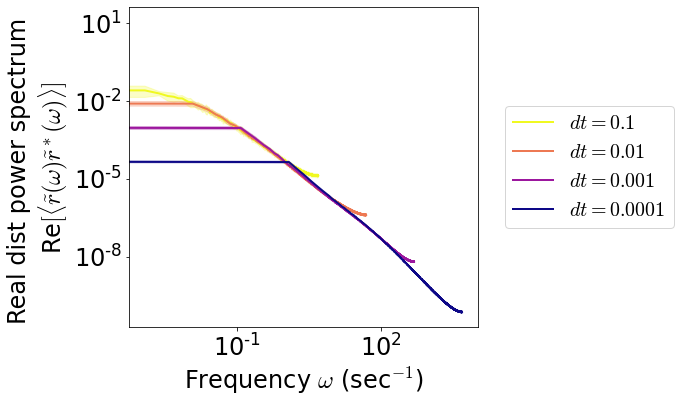

In [47]:
data_path_list = [
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod30",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod30",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod30"
                  ]
time_snap_list = [.1, .01, .001, .0001]
ci_bound=.95
ss_ind=-8191
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

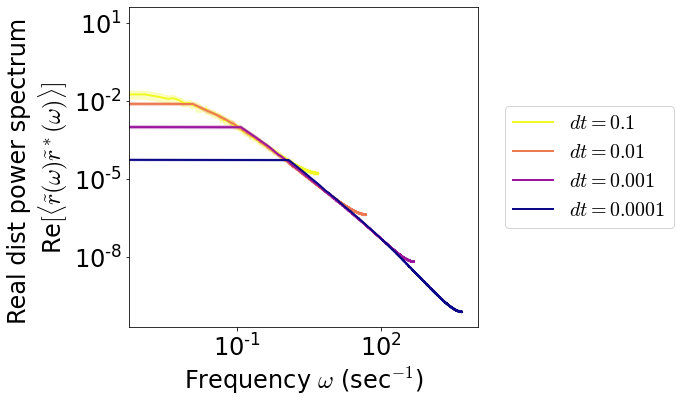

In [48]:
data_path_list = [
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod300",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod300",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod300"
                  ]
time_snap_list = [.1, .01, .001, .0001]
ci_bound=.95
ss_ind=-8191
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

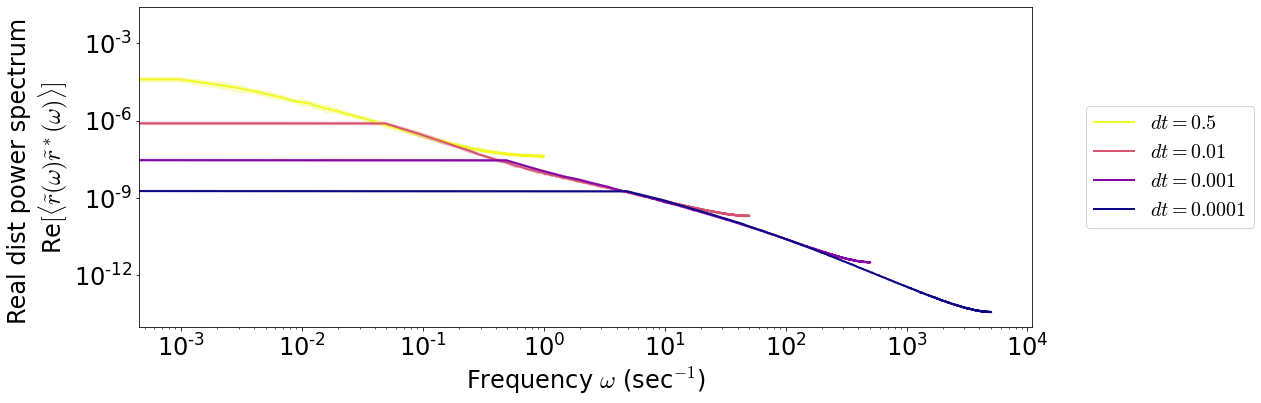

In [117]:
data_path_list = [cond_path / "22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod1",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod1"
                  ]
time_snap_list = [.5, .01, .001, .0001]
ci_bound=.95
ss_ind=-2047
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(18, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

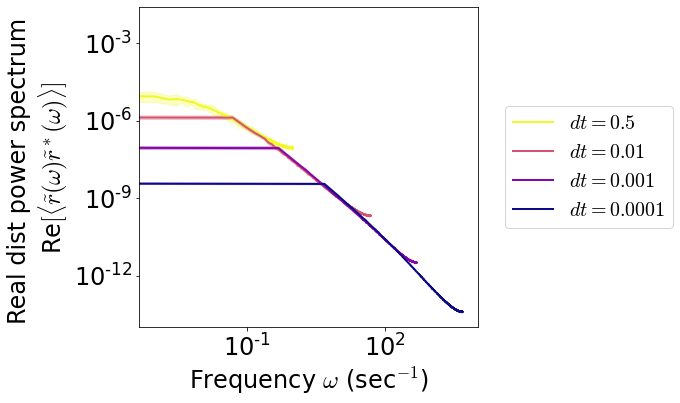

In [119]:
data_path_list = [cond_path / "22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod300",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod300",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod300",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod300"
                  ]
time_snap_list = [.5, .01, .001, .0001]
ci_bound=.95
ss_ind=-2047
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

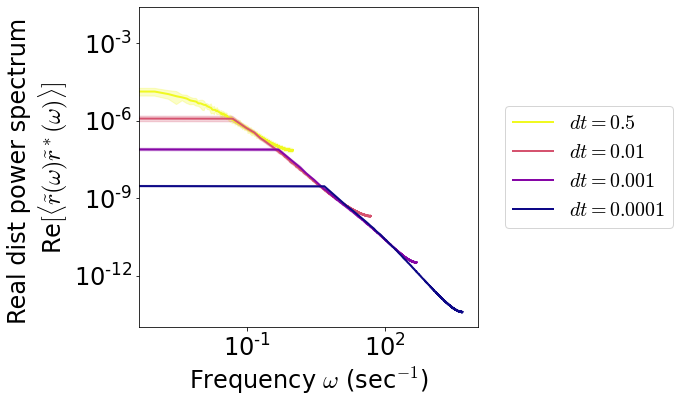

In [21]:
data_path_list = [cond_path / "22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod30",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations/kod30",
                  cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod30"
                  ]
time_snap_list = [.5, .01, .001, .0001]
ci_bound=.95
ss_ind=-2047
end_ind=-1
start_bead=0
end_bead=None
label_str = '$dt$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, pd in tqdm(enumerate(data_path_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

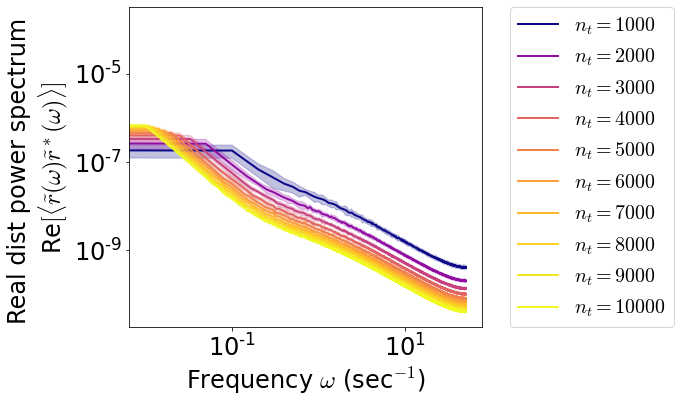

In [123]:
pd = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations/kod0.1"

# time_snap_list = (np.power(2, np.arange(9,14)) - 1).tolist()
time_snap_list = (np.arange(1000,11000,1000)).tolist()
ci_bound=.95
end_ind=-1
start_bead=0
end_bead=None
label_str = '$n_t$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, ss_ind in tqdm(enumerate(time_snap_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, -ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

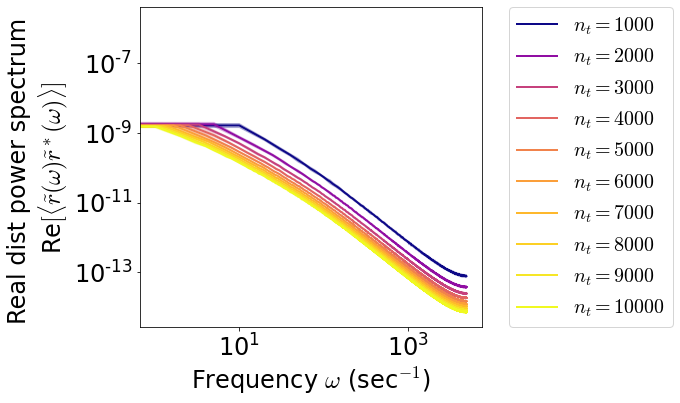

In [125]:
pd = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations/kod0.1"

# time_snap_list = (np.power(2, np.arange(9,14)) - 1).tolist()
time_snap_list = (np.arange(1000,11000,1000)).tolist()
ci_bound=.95
end_ind=-1
start_bead=0
end_bead=None
label_str = '$n_t$'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
try:
    log_pvs = np.log10(time_snap_list)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

    avg_power_spec_list = []
    std_power_spec_list = []
    for i, ss_ind in tqdm(enumerate(time_snap_list)):
        power_spec_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        # TODO Go through and check to see if one of the seeds didn't finish.
        #      If so, make that the new end_ind if it is less than the end_ind 
        #      given.

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][:]
            dt = time_arr[2]-time_arr[1]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                    :, -ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            power_spec, freqs  = poly_dist_power_spec(com_arr,dt)
            power_spec_list += [power_spec]
        power_spec_mat = torch.stack([avg for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
        std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
        
        # label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {time_snap_list[i]}$")
        ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
        _ = ax.fill_between(freqs, 
                            (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                            color=colors[i], alpha=.25)

    _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
    _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    # _ = ax.set_ylim(0.0001)

    _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()
    pass

0it [00:00, ?it/s]

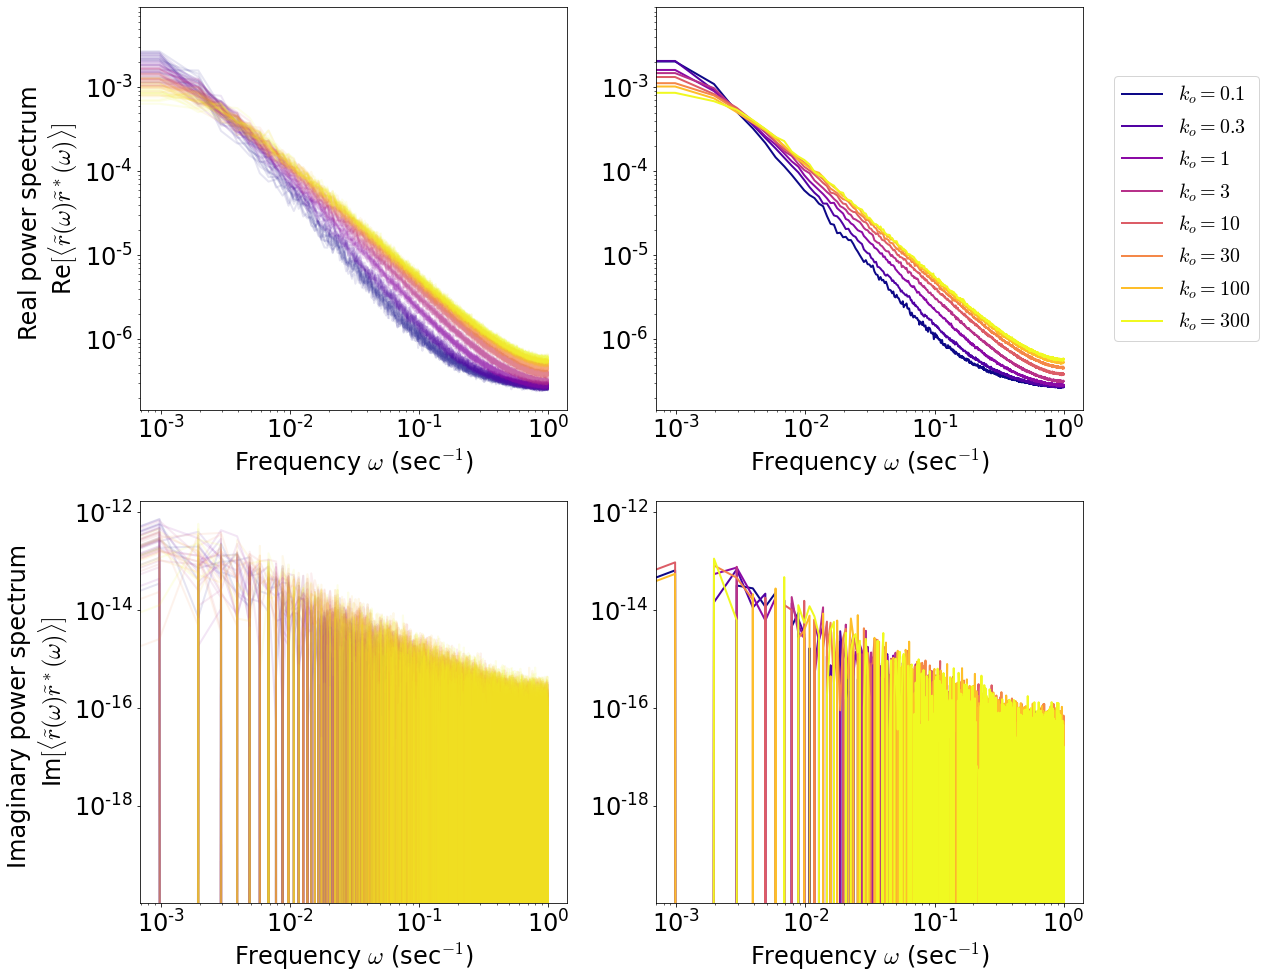

In [60]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
fig, axarr = plt.subplots(2, 2, figsize=(18, 14))
power_spec_graph_func(fig, axarr, data_path, 'kod', '$k_o$',
                        ss_ind = -2047,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

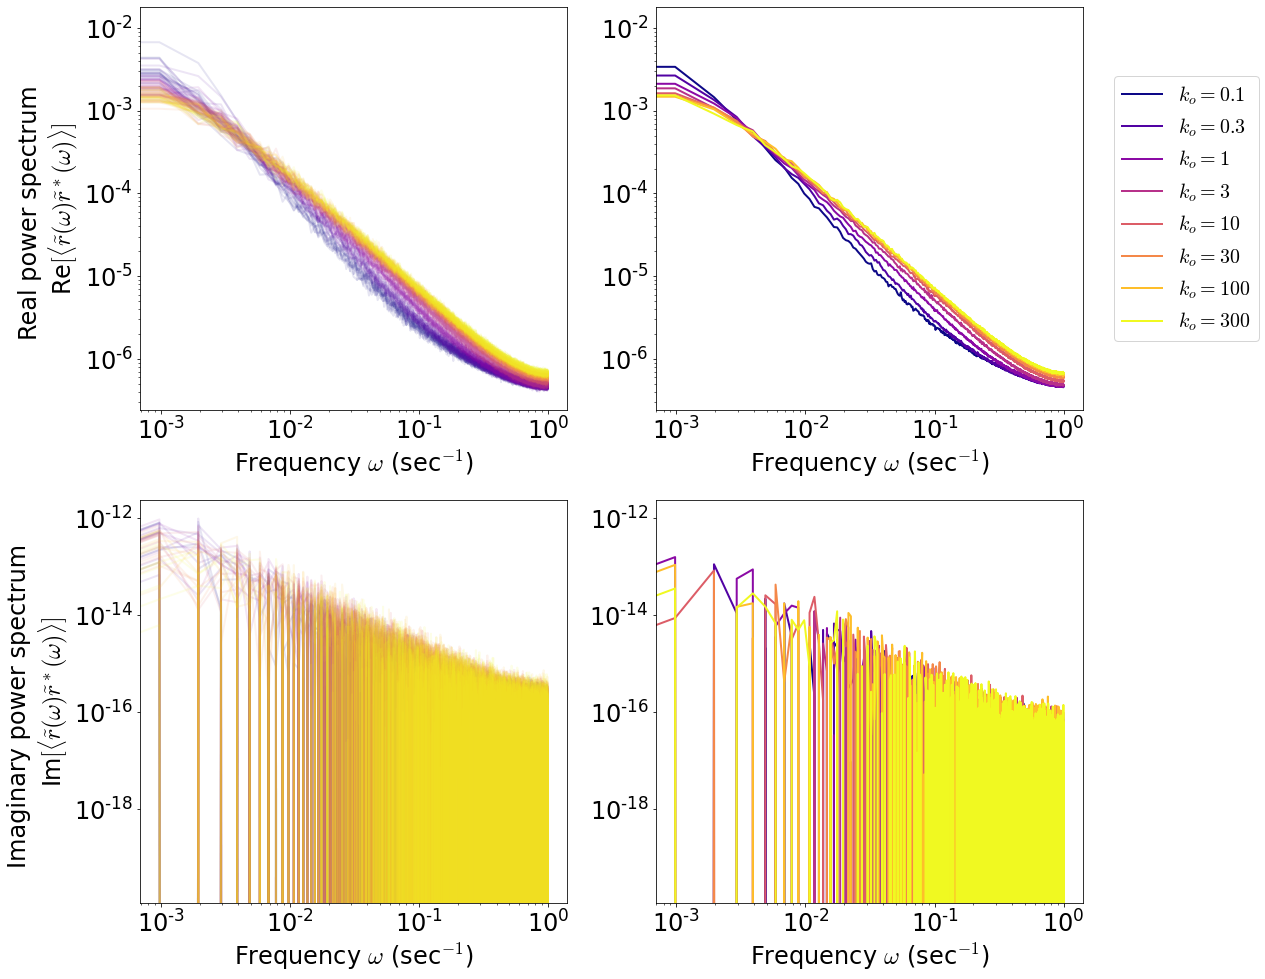

In [33]:
data_path = (cond_path / "22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations") 
fig, axarr = plt.subplots(2, 2, figsize=(18, 14))
power_spec_graph_func(fig, axarr, data_path, 'kod', '$k_o$',
                        ss_ind = -2047,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

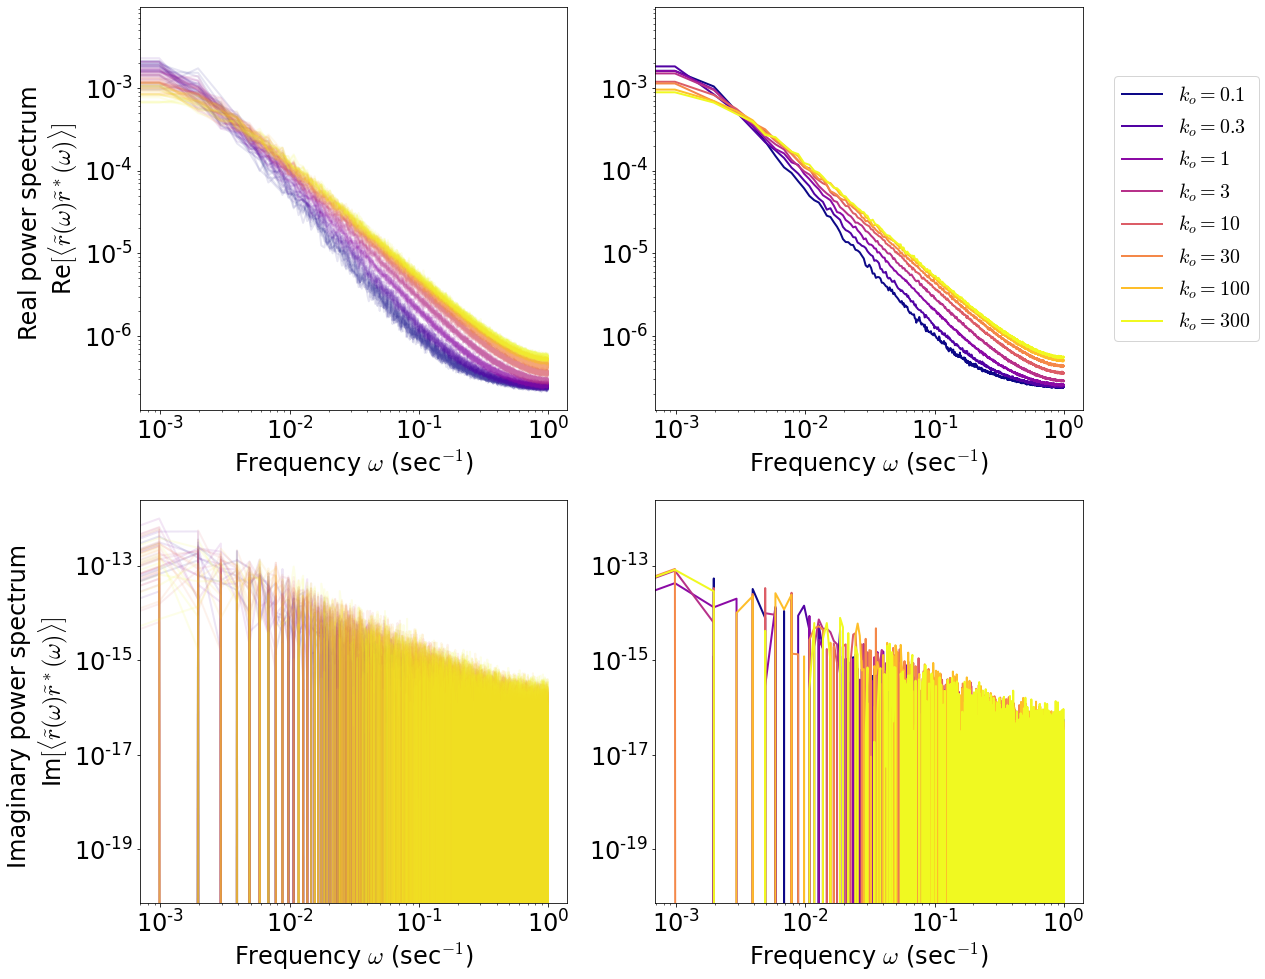

In [34]:
data_path = (cond_path / "22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations") 
fig, axarr = plt.subplots(2, 2, figsize=(18, 14))
power_spec_graph_func(fig, axarr, data_path, 'kod', '$k_o$',
                        ss_ind = -2047,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

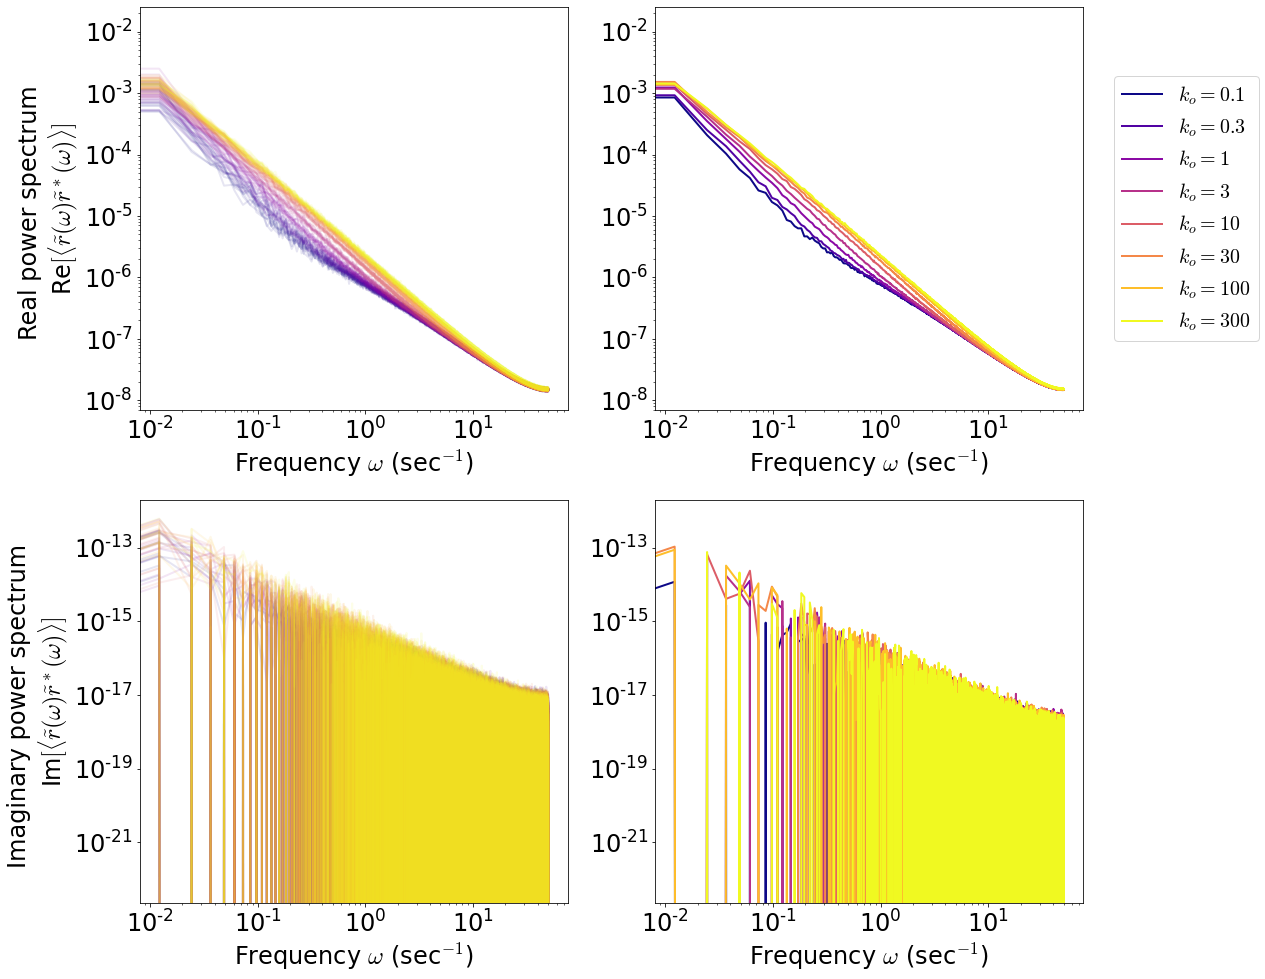

In [35]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/simulations" 
fig, axarr = plt.subplots(2, 2, figsize=(18, 14))
power_spec_graph_func(fig, axarr, data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

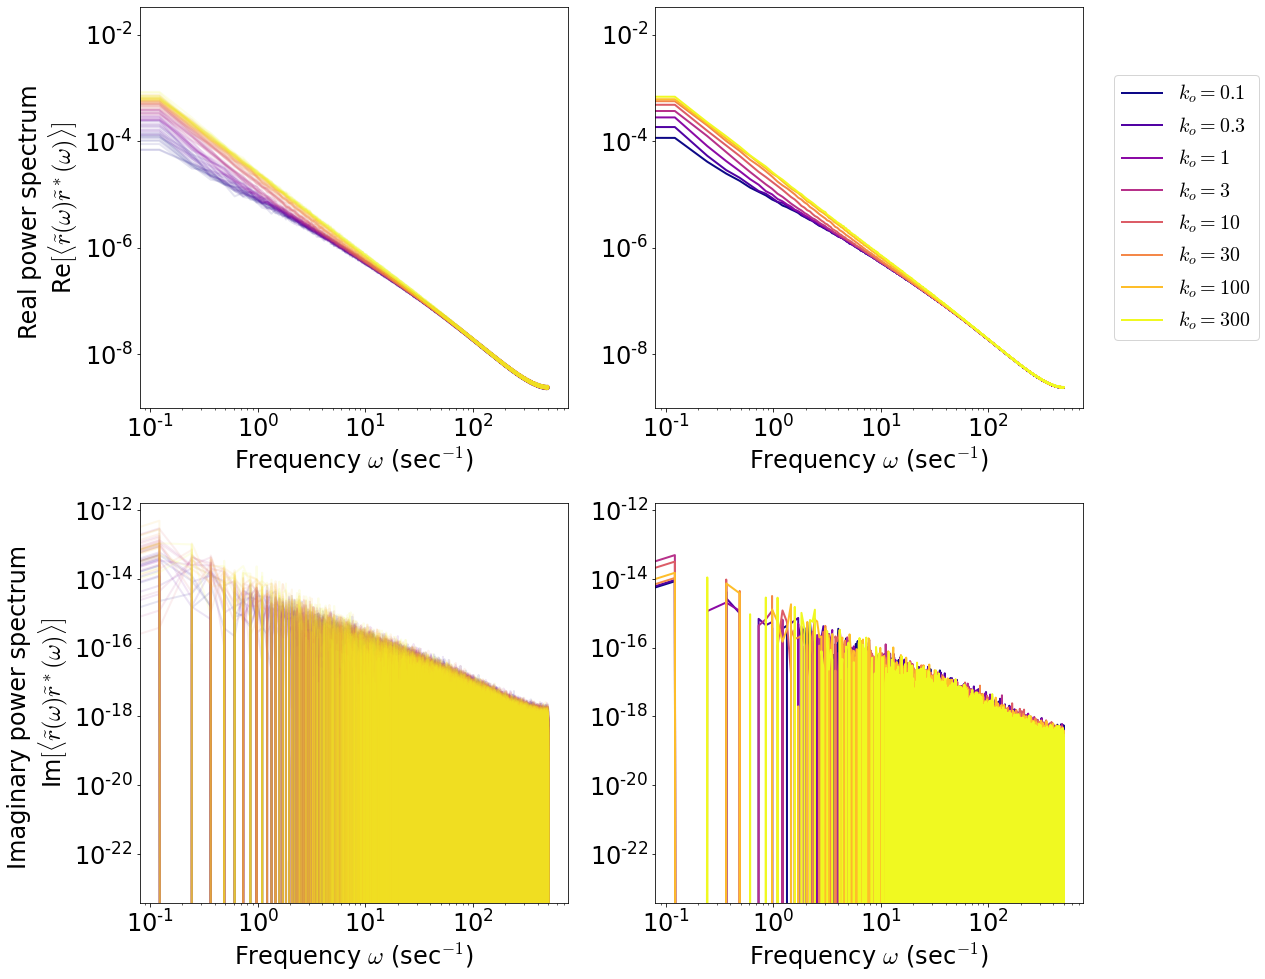

In [36]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations" 

fig, axarr = plt.subplots(2, 2, figsize=(18, 14))
power_spec_graph_func(fig, axarr, data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)

0it [00:00, ?it/s]

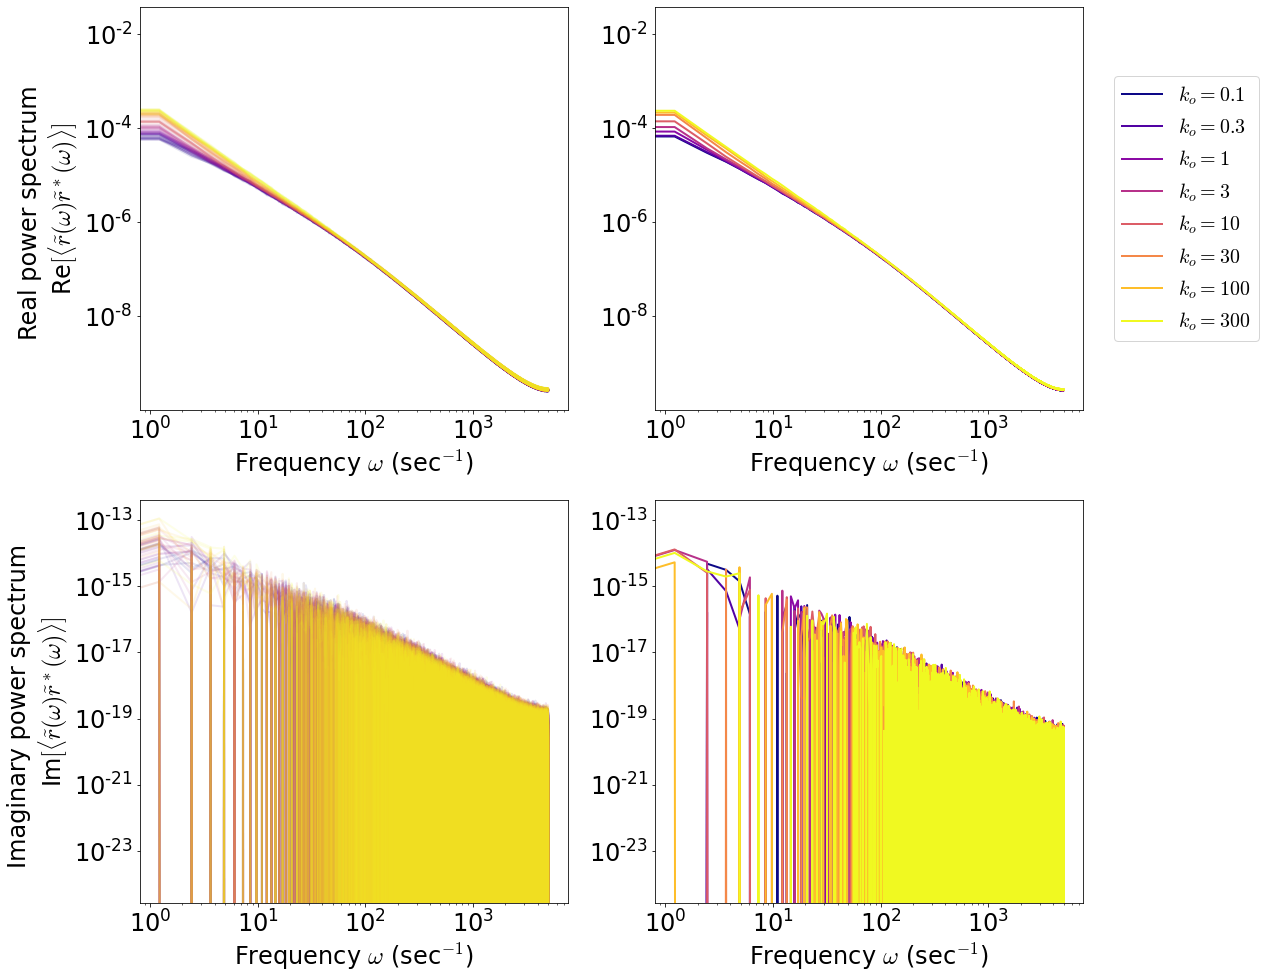

In [37]:
data_path = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/simulations" 
fig, axarr = plt.subplots(2, 2, figsize=(18, 14))
power_spec_graph_func(fig, axarr, data_path, 'kod', '$k_o$',
                        ss_ind = -8191,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None)